# Exploring Relationships
This notebook exists to perform basic EDA on our Wildfire dataset and determine what relationships and correlations exist between variables.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [ ]:
# Load the datasets
df = pd.read_csv(r"/media/scruffy/Elements/python_data/Final/Prepared_Data/final_data.csv")
fires = pd.read_csv(r"/media/scruffy/Elements/python_data/Final/Prepared_Data/wildfires_california.csv")

In [3]:
# Set style for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Correlation Matrix

In [12]:
# Downsample the majority class to handle extreme class imbalance (>99.9% no fire condition)
# Separate majority and minority classes
df_majority = df[df['active_fire'] == False]
df_minority = df[df['active_fire'] == True]

# Downsample majority class
if len(df_minority) > 0:
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,
                                     n_samples=len(df_minority),
                                     random_state=42)
    
    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [13]:
# Select numeric columns only (excluding id, date, and geometry-related columns)
numeric_cols = df_balanced.drop(columns=['longitude', 'latitude', 'point_id']).select_dtypes(include=[np.number]).round(2).columns.tolist()

In [18]:
# Compute correlations with target
correlations = df_balanced[numeric_cols + ['active_fire']].corr()

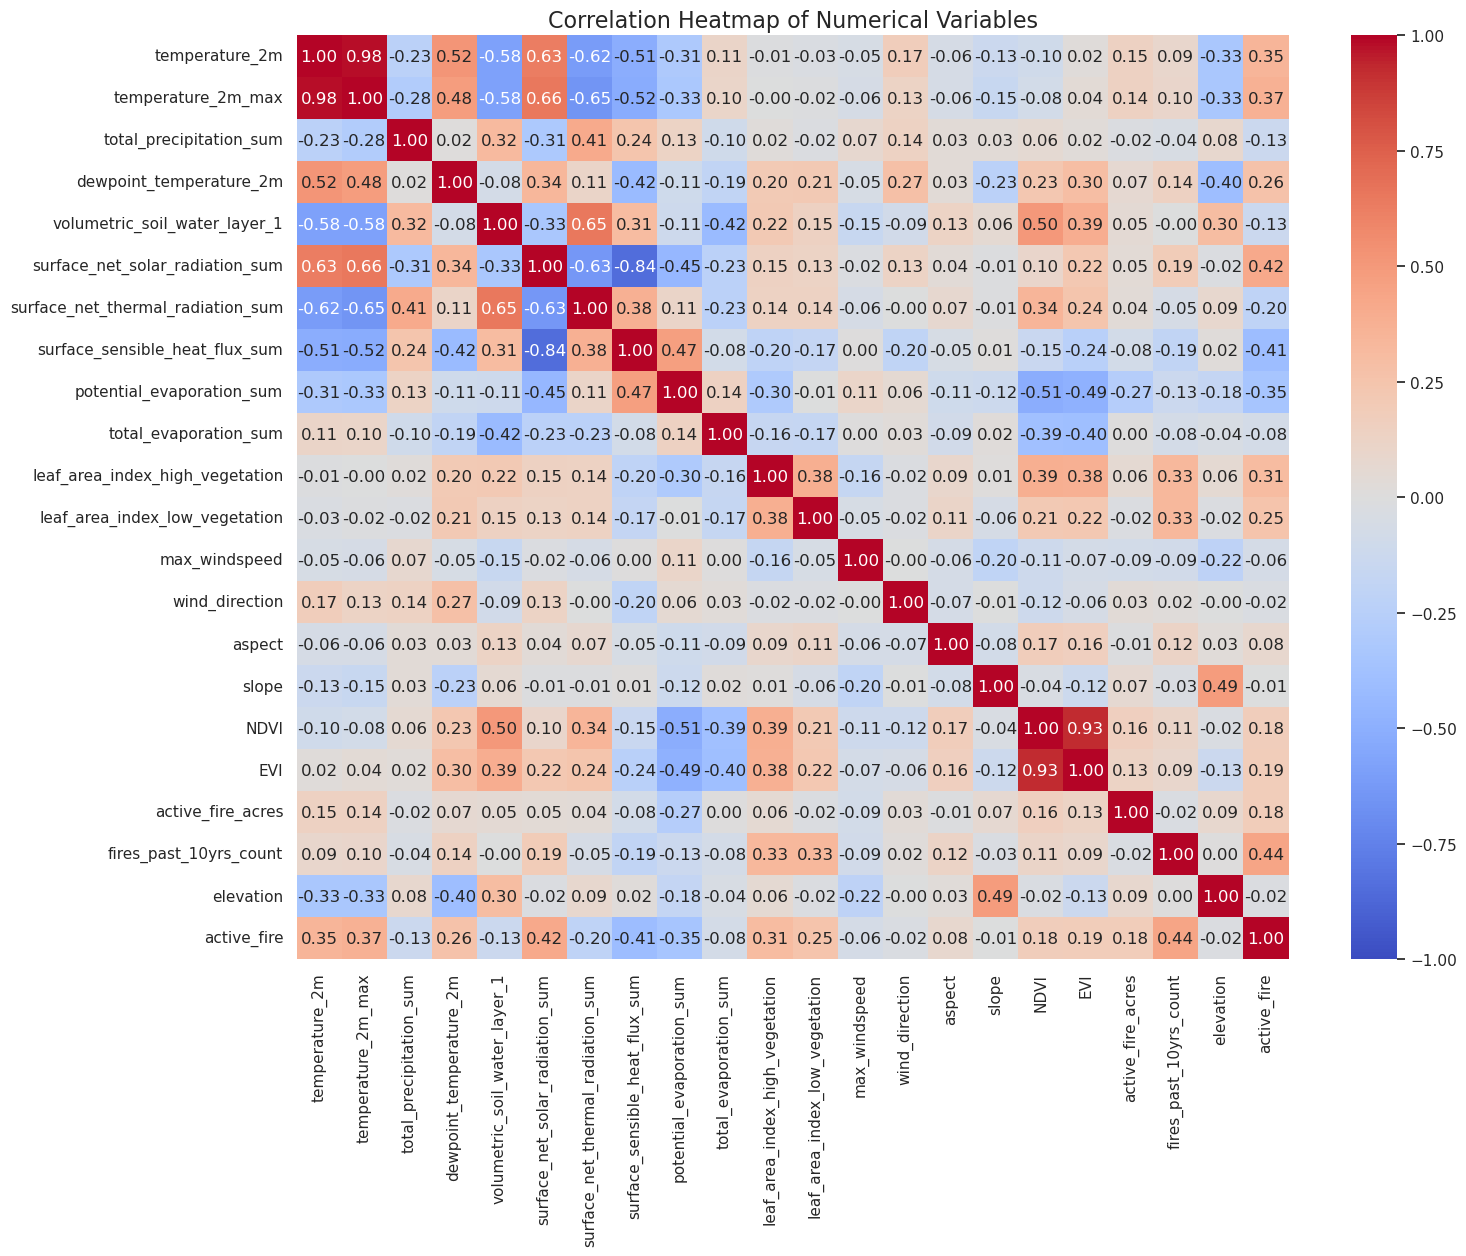

In [16]:
# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, 
    vmax=1
)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

### Correlation Analysis
- Strongest correlations to fire condition: historical fire count, solar radiation and temperature, vegetation density/health.
- Surprising total lack of correlation: slope, windspeed. Not consistent with domain research, could be confounding variables. Might try creating a new feature comparing wind direction with slope aspect to isolate unusually strong winds blowing uphill.
- Variable cross-correlation all looks logical. Most variables not strongly correlated, those that are make sense (e.g. soil moisture/vegeatation health, temperature/solar radiation, slope/elevation etc.)

### 2. Scatter Plots

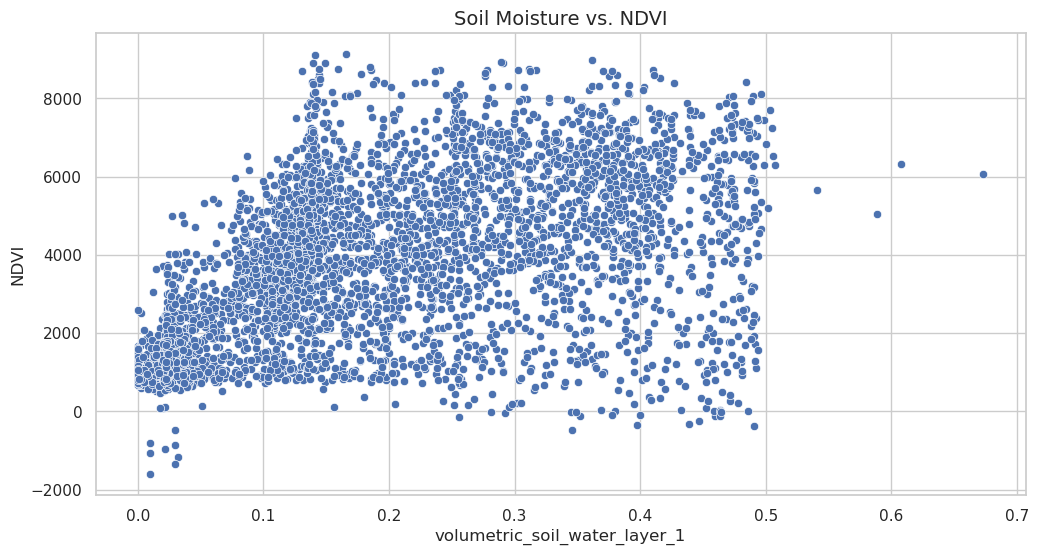

In [30]:
sns.scatterplot(
    data=df.sample(5000),
    x="volumetric_soil_water_layer_1",
    y="NDVI",
    hue="active_fire",
    palette=['red','blue']
)
plt.title("Soil Moisture vs. NDVI", fontsize=14)
plt.show()

### Discussion
- There is an intuitive and obvious connection between soil moisture levels and vegetation health, which is borne out in the data.
- Interestingly those outliers show up across a number of variable comparisons. These are in the delta region where the San Joaquin and Sacramento Rivers converge.

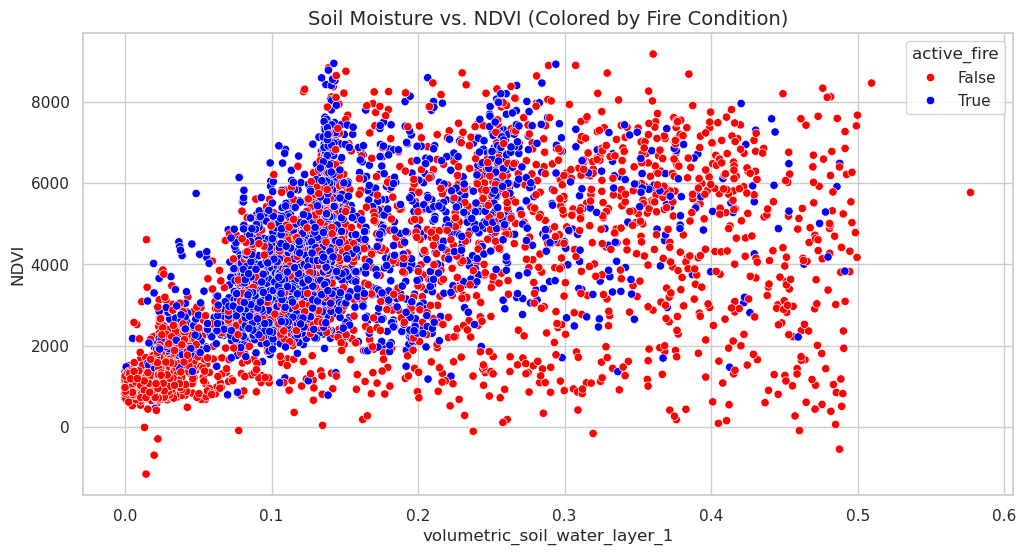

In [89]:
sns.scatterplot(
    data=df_balanced.sample(5000),
    x="volumetric_soil_water_layer_1",
    y="NDVI",
    hue="active_fire",
    palette=['red','blue']
)
plt.title("Soil Moisture vs. NDVI (Colored by Fire Condition)", fontsize=14)
plt.show()

### Discussion
- Fires very unlikely where both soil moisture and vegetation health are low.
- Definite "sweet spot" for fire likelihood where soil moisture is low but not so low that it chokes the fuel supply.

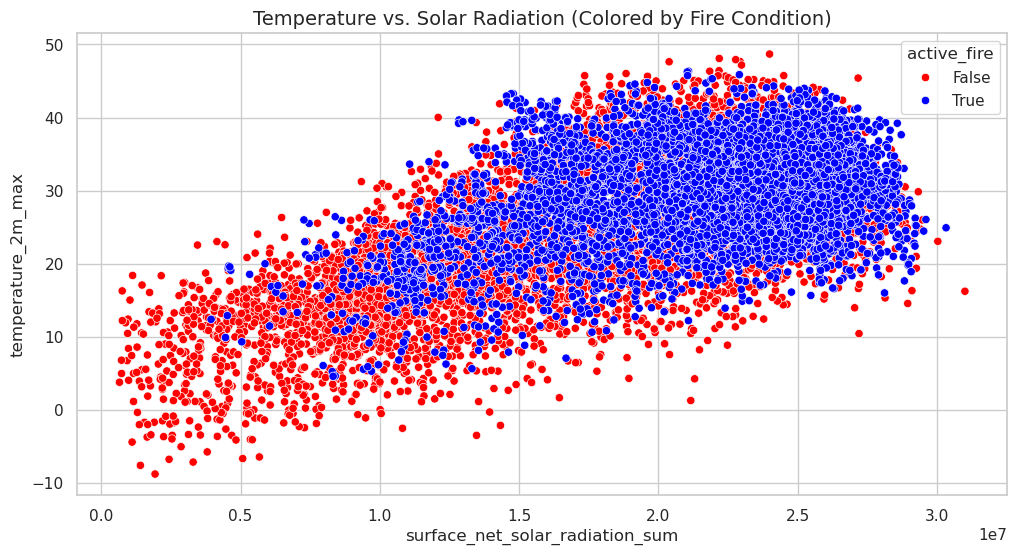

In [87]:
sns.scatterplot(
    data=df_balanced,
    x="surface_net_solar_radiation_sum",
    y="temperature_2m_max",
    hue="active_fire",
    palette=['red','blue']
)
plt.title("Temperature vs. Solar Radiation (Colored by Fire Condition)", fontsize=14)
plt.show()

### Discussion
- Very strong linear relationship between total solar radiation and maximum daily temperature.
- Fires are virtually non-existent where solar radiation and temperature are both low.

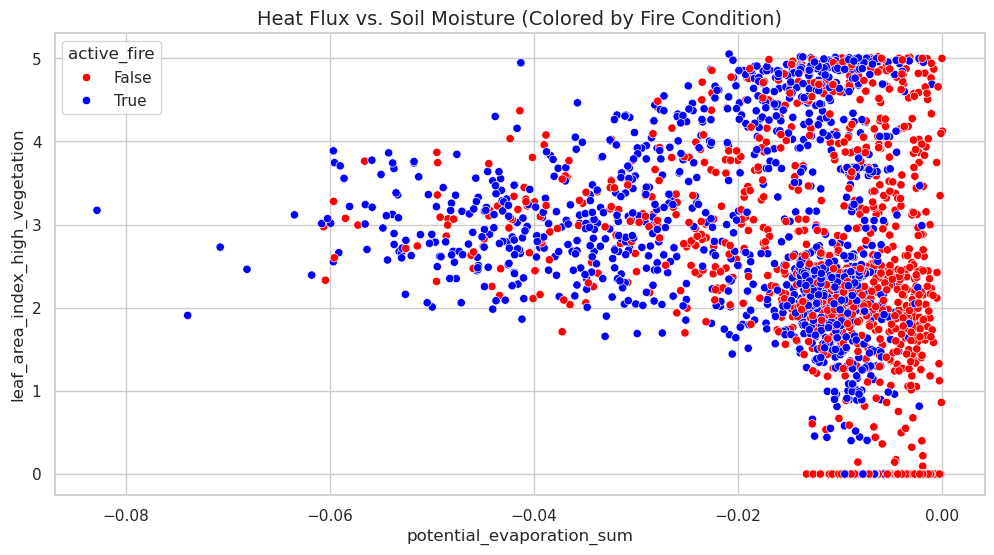

In [88]:
sns.scatterplot(
    data=df_balanced.sample(2500),
    x="potential_evaporation_sum",
    y="leaf_area_index_high_vegetation",
    hue="active_fire",
    palette=['red','blue']
)
plt.title("Heat Flux vs. Soil Moisture (Colored by Fire Condition)", fontsize=14)
plt.show()

### Discussion
- Overall negative relationship between the Leaf Area Index for the "High" vegetation type (a measure of green leaf density in a region, i.e. vegetation coverage) and potential evaporation sum.
- However, at least from this sample, there appear to be two distinct clusters, one where LAI is higher despite higher potential evaporation. Should investigate geographical/temporal distributions of these data.

### 3. Pair Plot

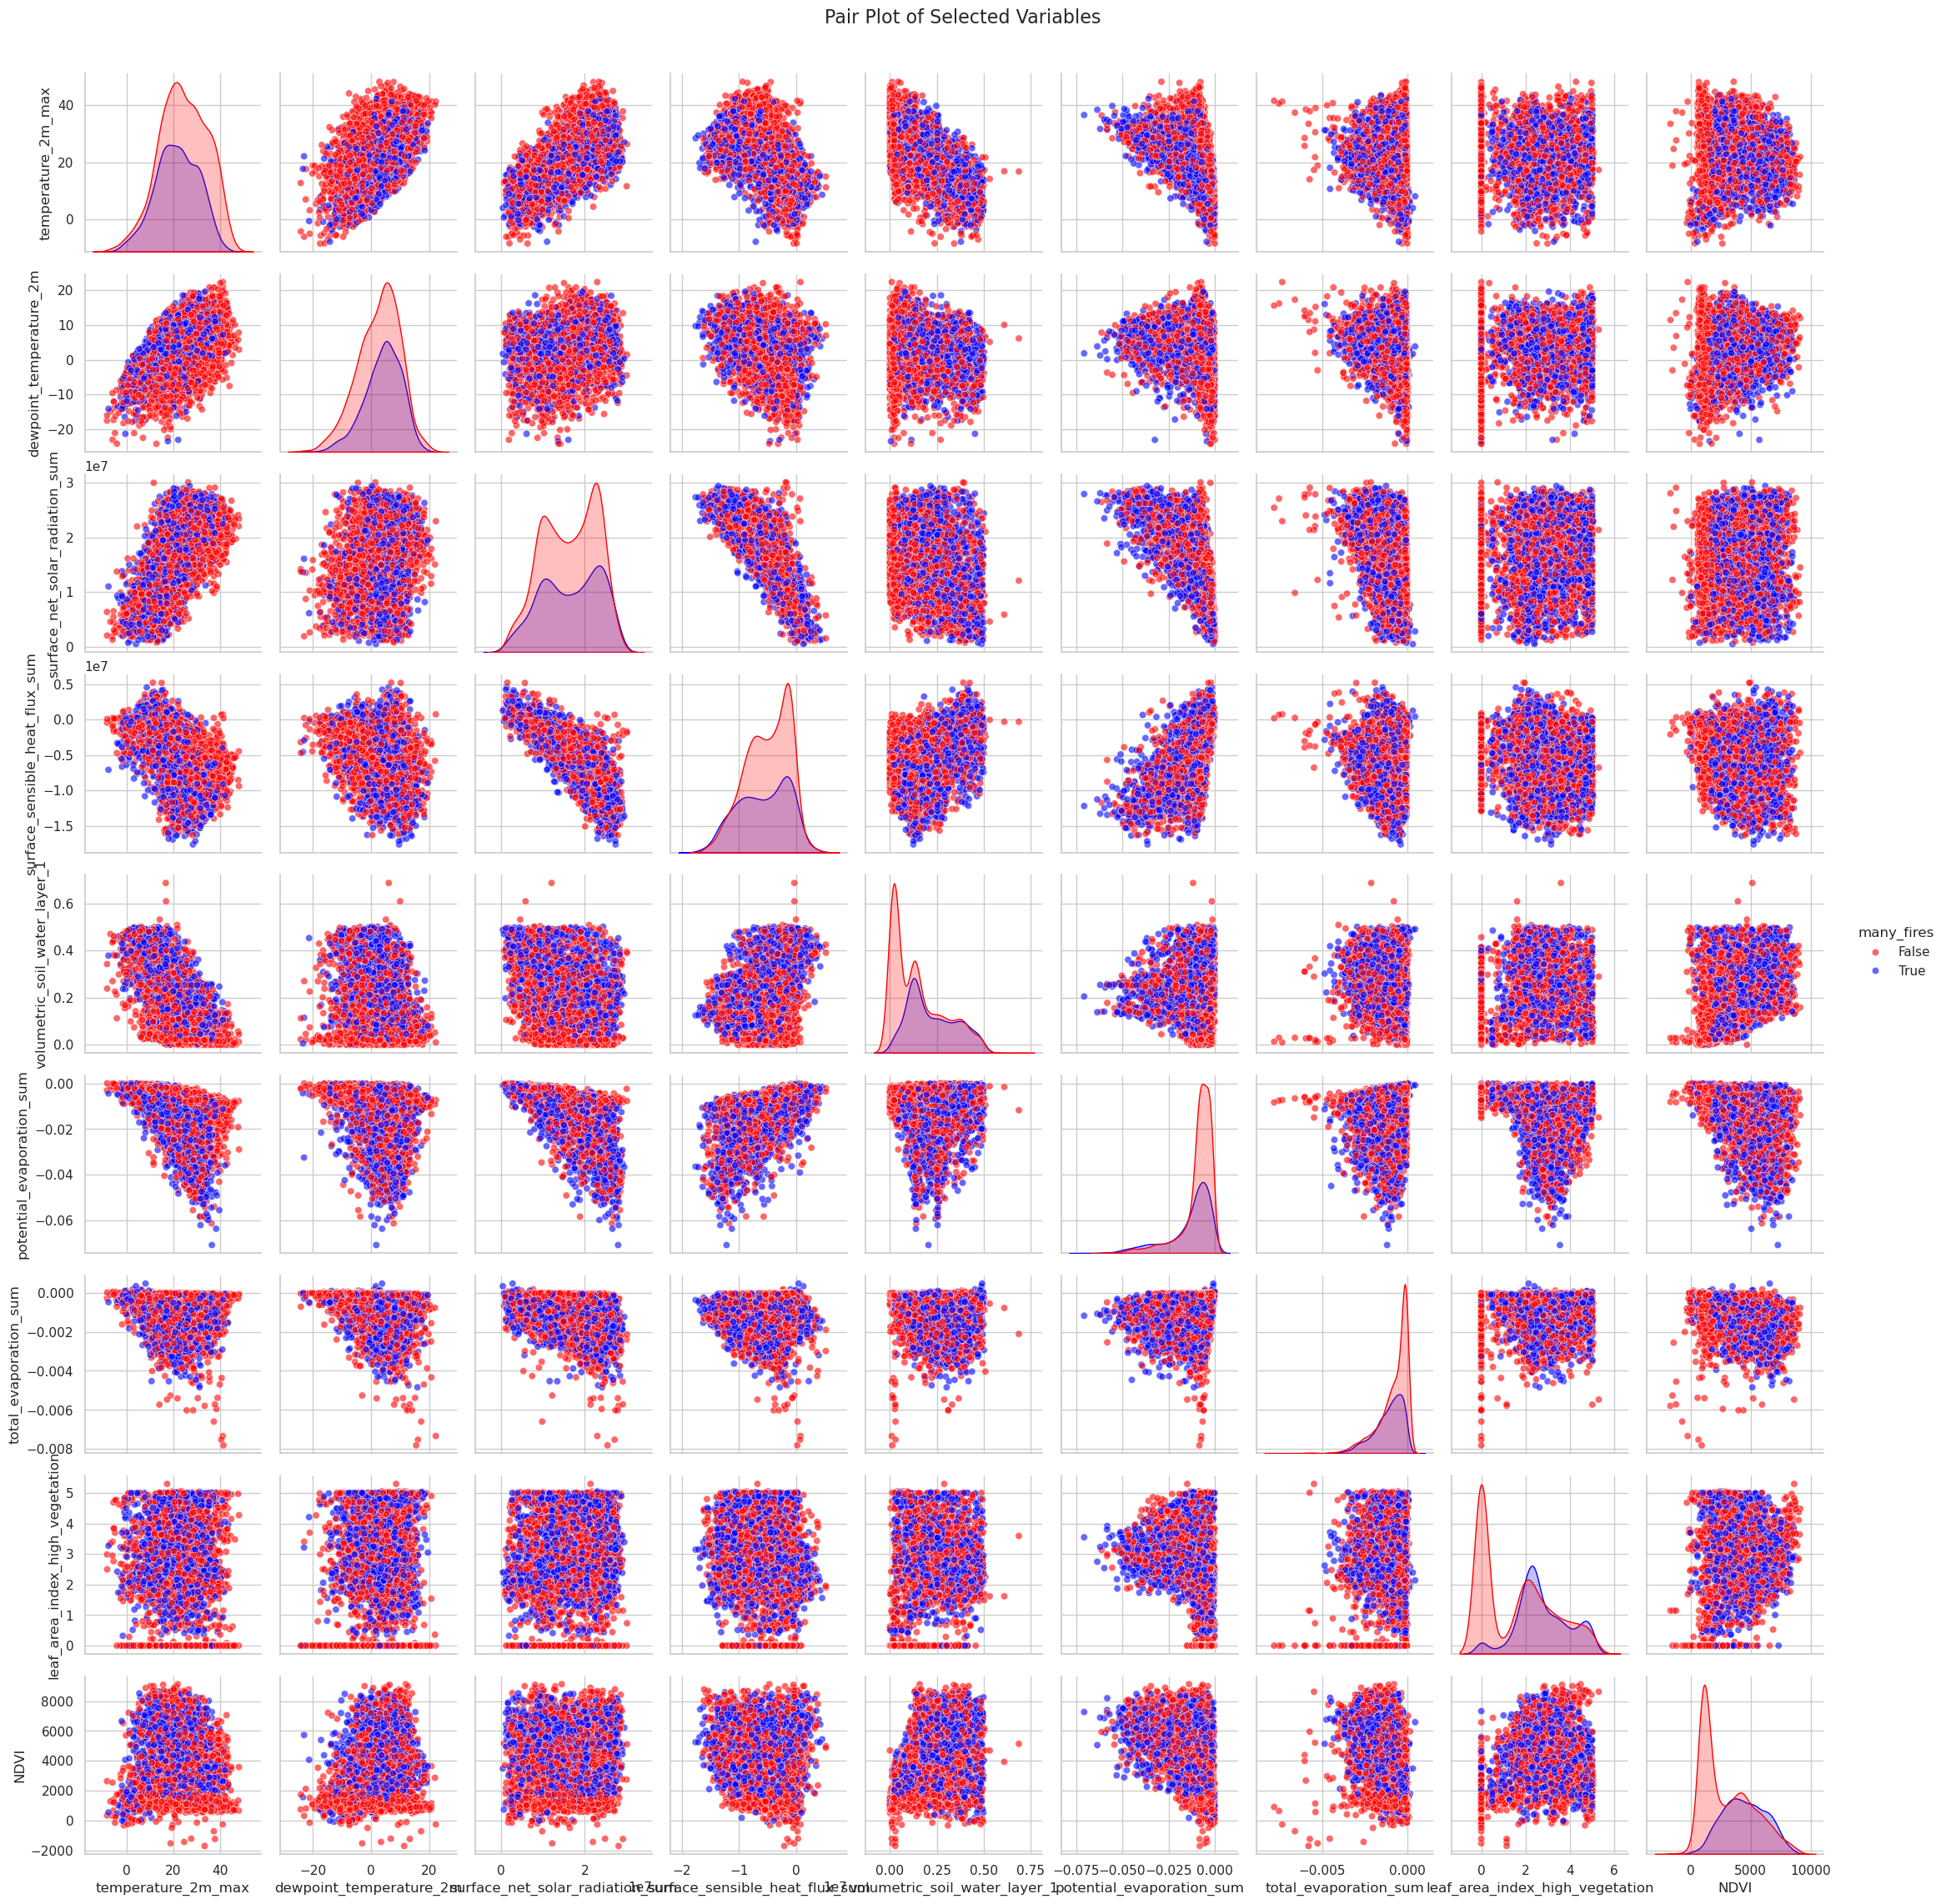

In [42]:
# Select a subset of columns for the pair plot
selected_cols = [
    "temperature_2m_max",
    "dewpoint_temperature_2m",
    "surface_net_solar_radiation_sum",
    "surface_sensible_heat_flux_sum",
    "volumetric_soil_water_layer_1",
    "potential_evaporation_sum",
    "total_evaporation_sum",
    "leaf_area_index_high_vegetation",
    "NDVI",
    "active_fire"
]

# Plot
sns.pairplot(
    df[selected_cols].sample(5000),  # Sample to reduce computation time
    hue="many_fires",
    palette=["red", "blue"],
    diag_kind="kde",
    plot_kws={"alpha": 0.6}
)
plt.suptitle("Pair Plot of Selected Variables", y=1.02, fontsize=16)
plt.show()

### Discussion
- Very complicated visual, with unfortunately not a ton of useful info.
- Most compelling finding is that fires very unlikely where vegetation density and health are low.
- Other correlations are well-known or non-existent.

### 4. Categorical Plot

In [67]:
# Handle profound right-skew by taking log of acreage
fires['log_acres'] = np.log1p(fires['GIS_ACRES'])

# Limit dataset to recent fires to improve computation speed and accuracy
recent_fires = fires[fires['ALARM_DATE']>'2015-01-01']

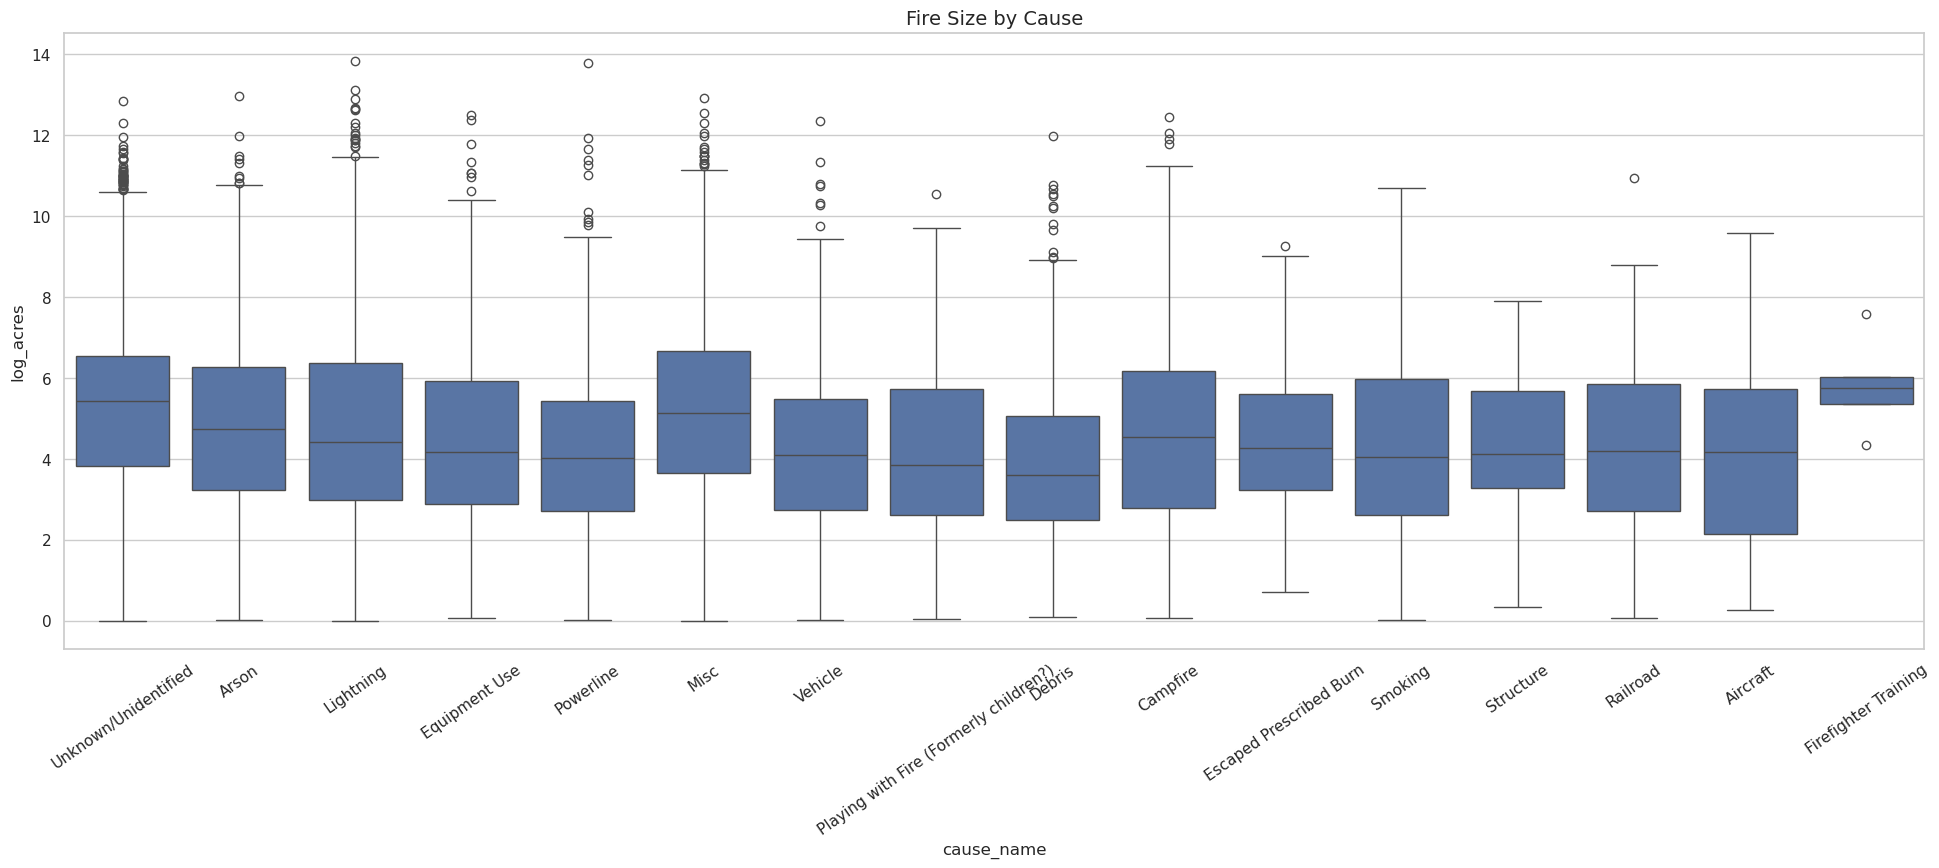

In [68]:
# Create a categorical plot (boxplot + stripplot)
plt.figure(figsize=(24, 8))
sns.boxplot(
    data=fires,
    x="cause_name",
    y="log_acres"
)
plt.xticks(rotation=35)
plt.title("Fire Size by Cause", fontsize=14)
plt.show()

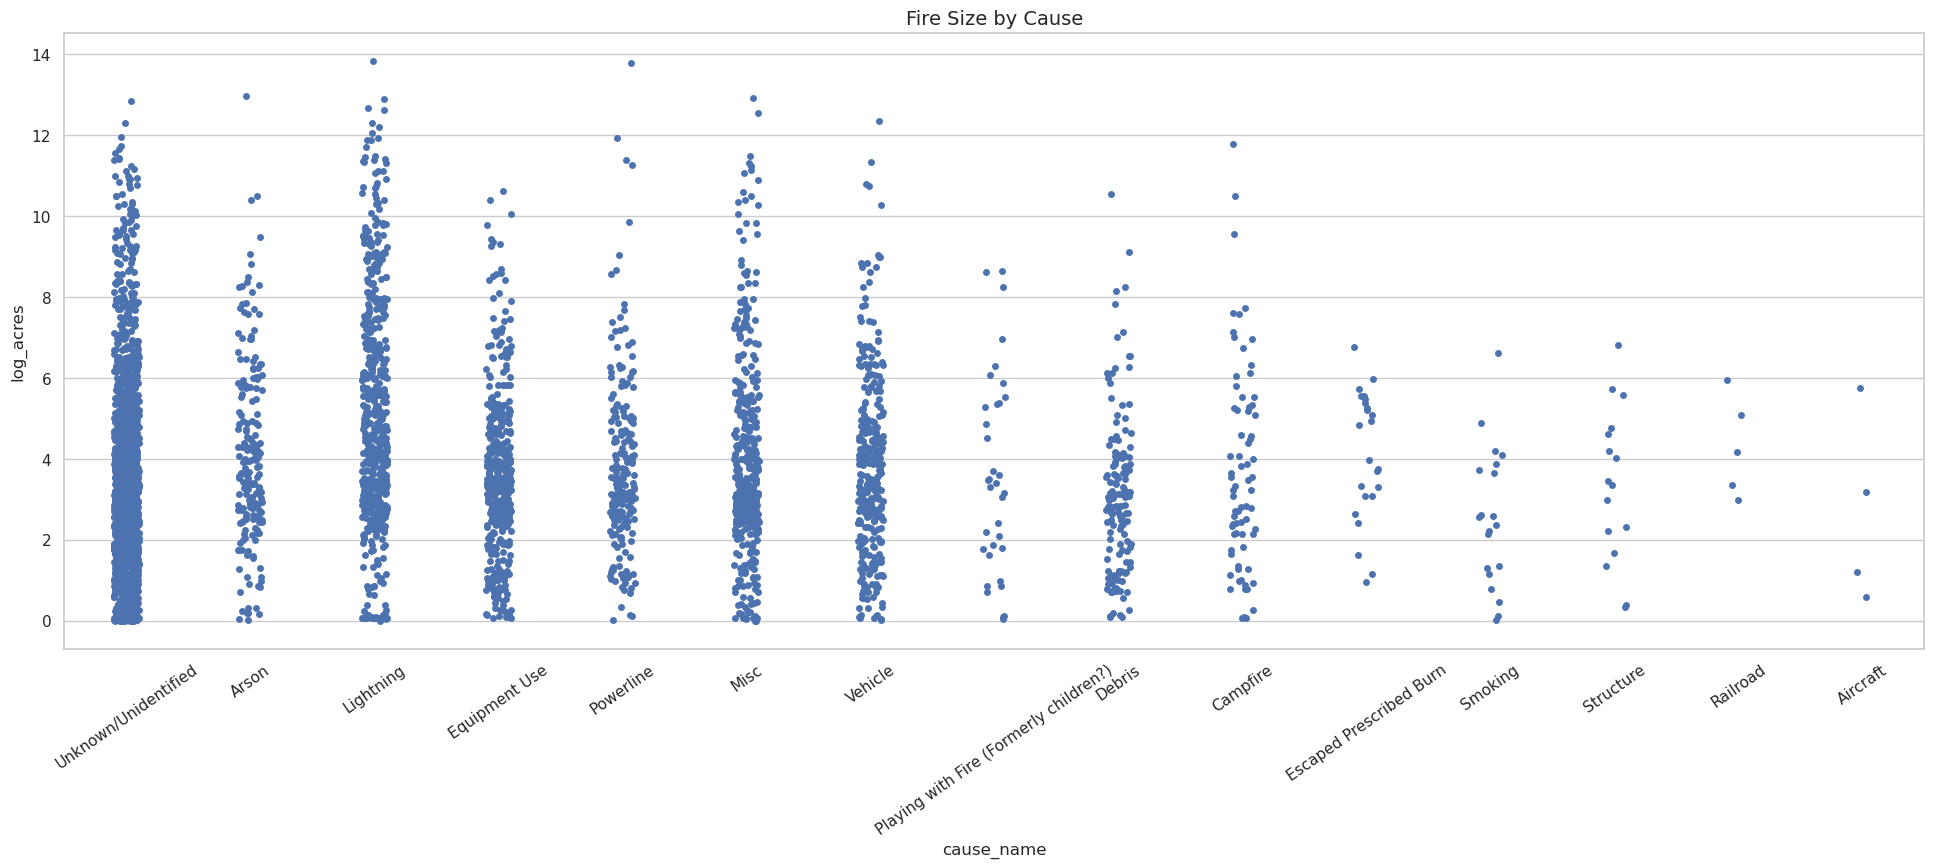

In [72]:
# Create a categorical plot (boxplot + stripplot)
plt.figure(figsize=(24, 8))
sns.stripplot(
    data=recent_fires,
    x="cause_name",
    y="log_acres"
)
plt.xticks(rotation=35)
plt.title("Fire Size by Cause", fontsize=14)
plt.show()

### Discussion
- Doesn't appear to be much difference in sizes of forest fires by cause, with the possible exception of Lightning fires which may be a bit larger.
- Since storms cover a large area very quickly, this could be because such fires have multiple ignition sites.

In [ ]:
fires = fires[fires['ALARM_DATE']>='2000-01-01']

In [13]:
numbycause = fires.groupby('cause_name')['geometry'].count().sort_values(ascending=False).to_frame()

In [16]:
numbysrc = fires.groupby('cause_src')['geometry'].count().sort_values(ascending=False).to_frame()

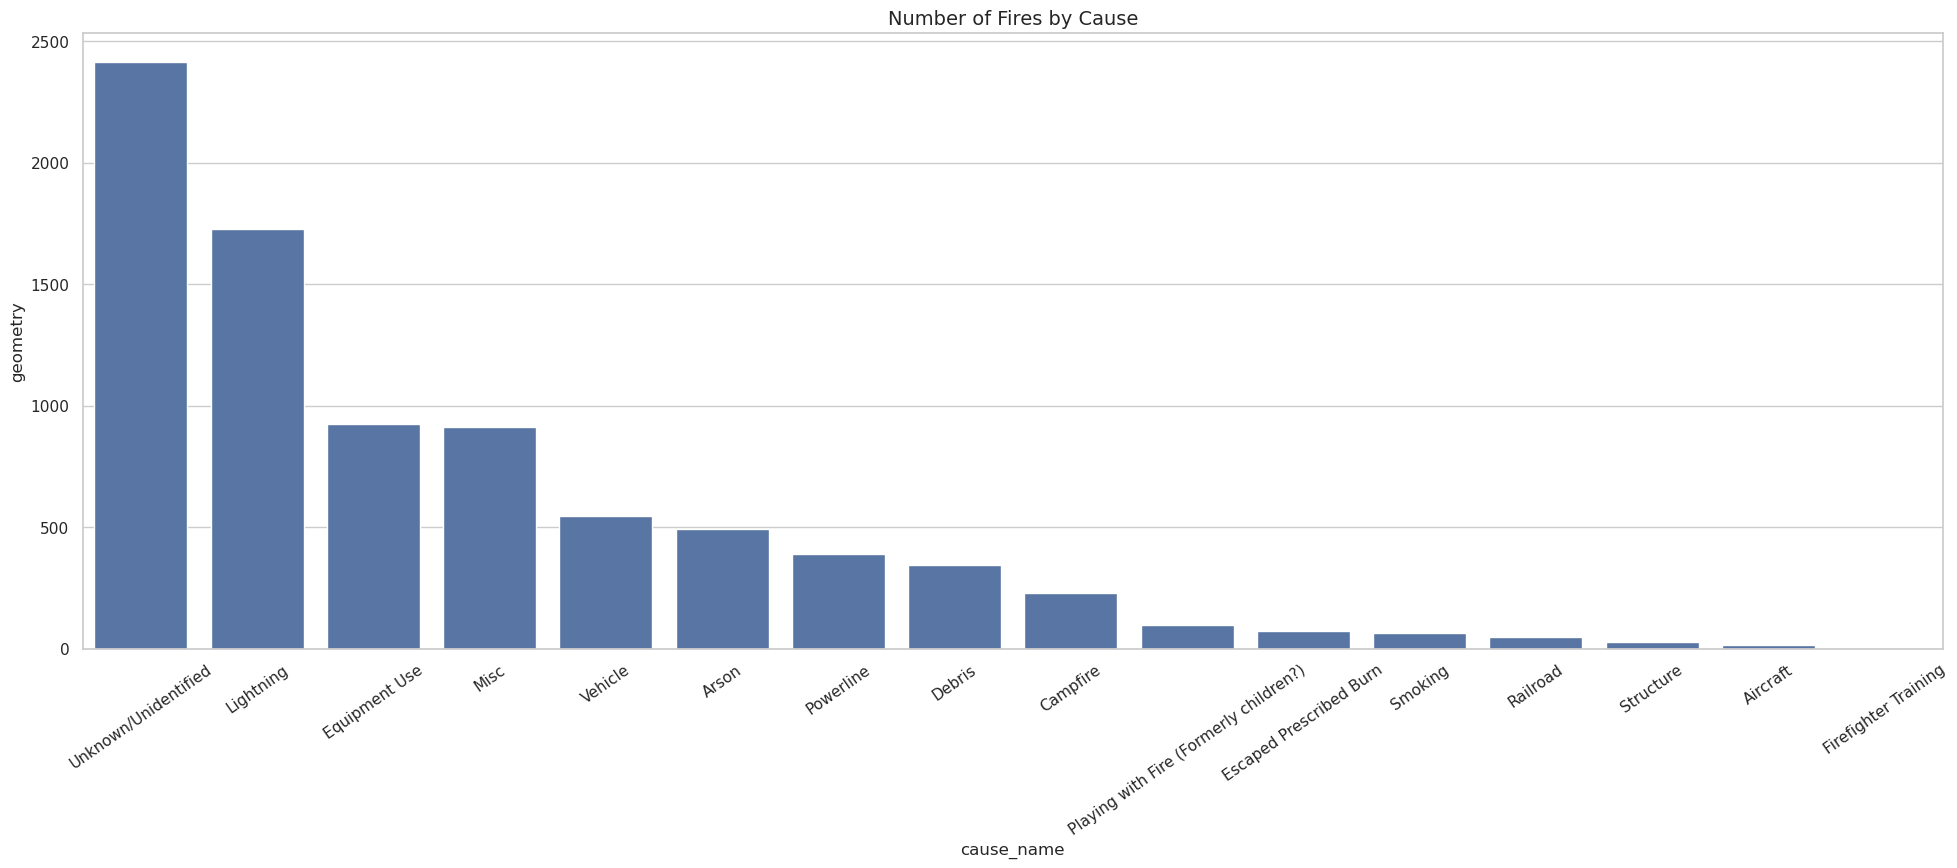

In [19]:
plt.figure(figsize=(24, 8))
sns.barplot(
    data=numbycause,
    x="cause_name",
    y="geometry"
)
plt.xticks(rotation=35)
plt.title("Number of Fires by Cause", fontsize=14)
plt.show()

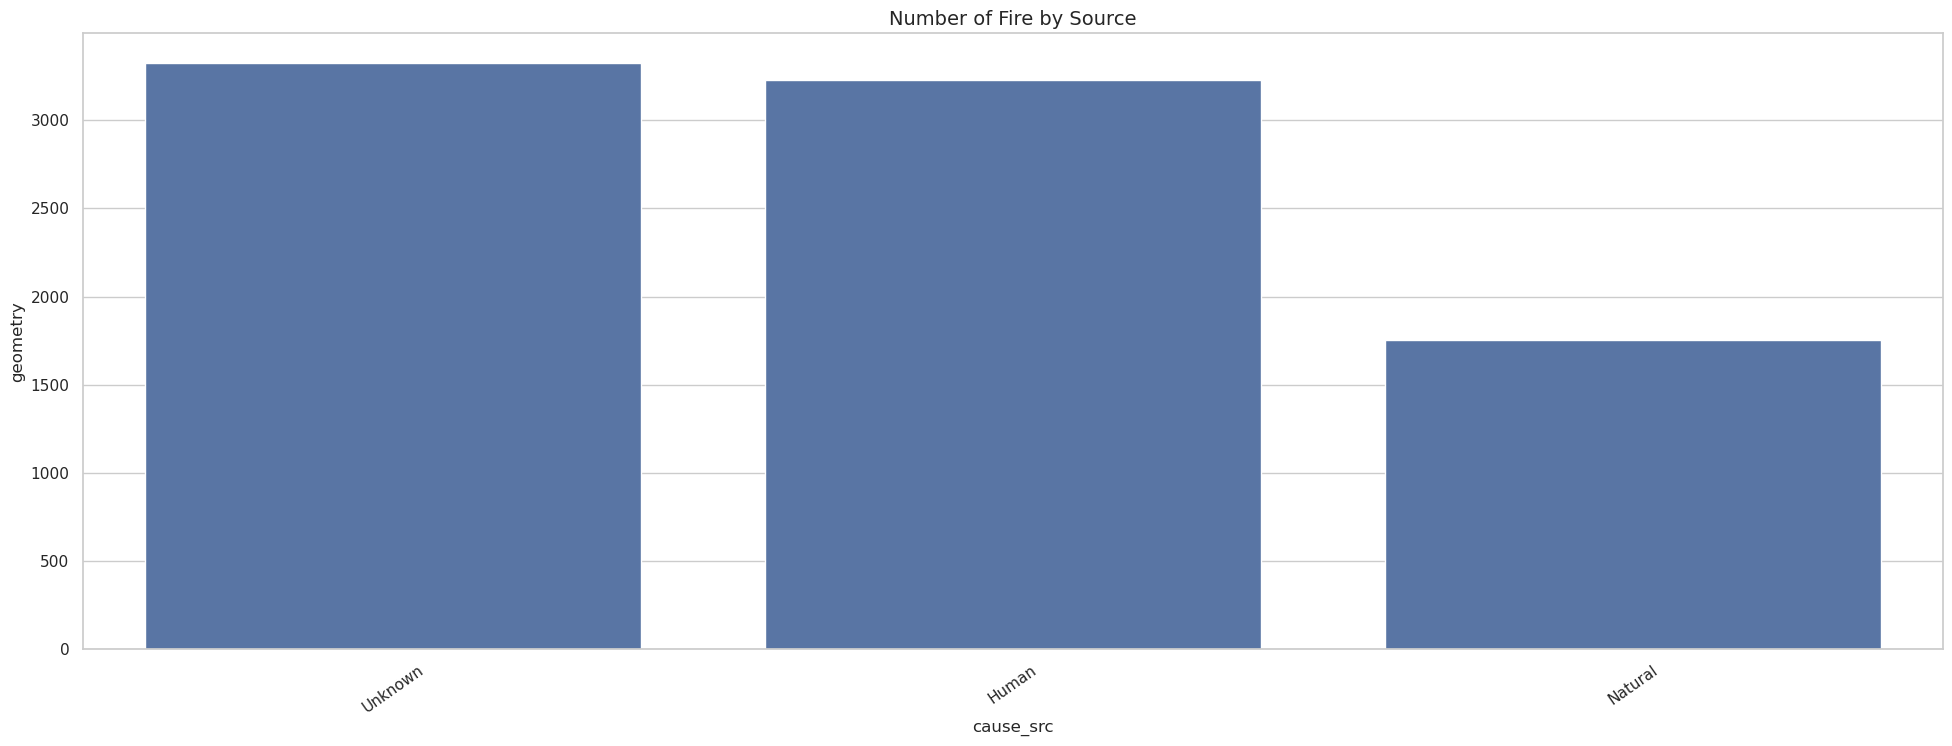

In [18]:
plt.figure(figsize=(24, 8))
sns.barplot(
    data=numbysrc,
    x="cause_src",
    y="geometry"
)
plt.xticks(rotation=35)
plt.title("Number of Fire by Source", fontsize=14)
plt.show()

### Discussion
- Majority of fires since 2000 with known causes are caused by human activity.

### New Questions
    1. Humans are major drivers of wildfires and yet previously human activity has not been a factor in fire risk formalae. Can Machine Learning help us create more accurate wildfire predictions by accounting for human activity levels in a region?
    2. How might seasonal and local factors be affecting our data?

### Hypothesis
- Certain climate, vegetation, and geophysical factors are correlated with wildfire activity. Using these variables we can produce reliable predictions of where wildfires are likely to occur, how many acres they are likely to burn, and how long it will likely take to contain them.